### Imports

In [9]:
from functions.load_data import load_CIFAR_data, load_Google_Digit_Data, load_MNIST_data
from functions.attacks import attackTestSetBatch
from functions.models import conv_tropical_3layer_model, conv_relu_3layer_model
from tensorflow.keras import losses
import numpy as np

### LOAD DATA

In [10]:
# -- load MNIST data -- 
x_train, x_test, y_train, y_test = load_MNIST_data(desired_classes=[i for i in range(10)])
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [ ]:
# -- load CIFAR data --
x_train, x_test, y_train, y_test = load_CIFAR_data(desired_classes=[i for i in range(10)])
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)

In [ ]:
# -- load SVHN data --
x_train, x_test, y_train, y_test = load_Google_Digit_Data(desired_classes=[i for i in range(10)])
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)

### TROPICAL: Basic 3 convolutional layers model

In [11]:
# -- TROPICAL: fit model --
trop_model = conv_tropical_3layer_model(x_train=x_train, y_train=y_train)

# -- TROPICAL: attack model -- 
trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test, losses.CategoricalCrossentropy(),'Tropical')

# -- TROPICAL: evaluate -- 
# - before attack -
pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
y_tester = np.argmax(y_test, axis=1)
pre_correct_index = np.equal(pre_trop_preds, y_tester)
pre_correct_accuracy = np.average(pre_correct_index)
trop_model.evaluate(x_test, y_test)

# - after attack - 
post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
post_correct_index = np.equal(post_trop_preds, y_tester)
post_correct_accuracy = np.average(post_correct_index)
trop_model.evaluate(trop_x_test_att, y_test)

# - number maintaining prediction - 
maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))
print(pre_correct_accuracy, post_correct_accuracy, maintained_correct_pred)

Epoch 1/10
225/938 [======>.......................] - ETA: 7:20 - loss: 7047.1416 - accuracy: 0.1035

KeyboardInterrupt: 

In [6]:
from tensorflow.keras.utils import plot_model
from custom_layers.tropical_layers import TropConv2D
from custom_layers.initializers import BimodalNormalInitializer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D
from tensorflow.keras import initializers
import time
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'  # Modify this path to your Graphviz installation directory


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 32)          9248      
                                                                 
 flatten_2 (Flatten)         (None, 288)              

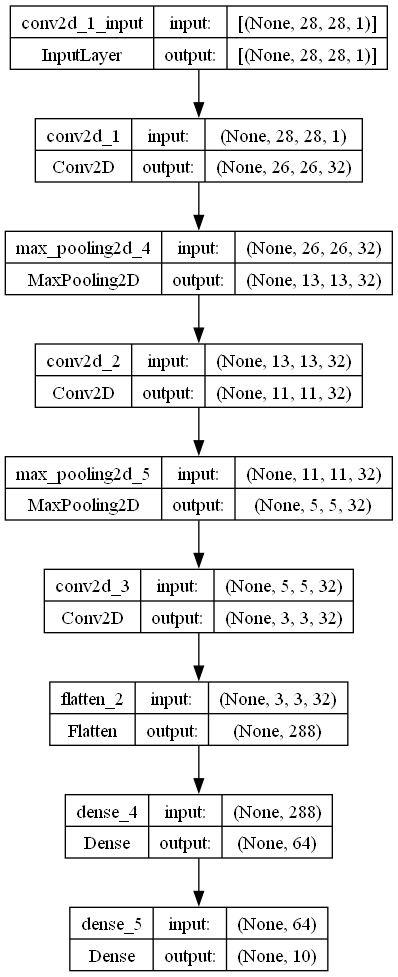

In [8]:
initializer_relu = initializers.RandomNormal(mean=0.5, stddev=1., seed=0)
final_layer_activation = 'softmax'
training_loss = 'categorical_crossentropy'
input_shape = (28, 28, 1)
model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
                    MaxPooling2D((2, 2)),                            
                    Conv2D(32, (3, 3), activation='relu'),
                    MaxPooling2D((2, 2)),
                    Conv2D(32, (3, 3), activation='relu'),
                    Flatten(),
                    Dense(64, activation='relu', kernel_initializer = initializer_relu),
                    Dense(10, activation=final_layer_activation, kernel_initializer = initializer_relu)])
model.build(input_shape=(32, 28, 28, 1))
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

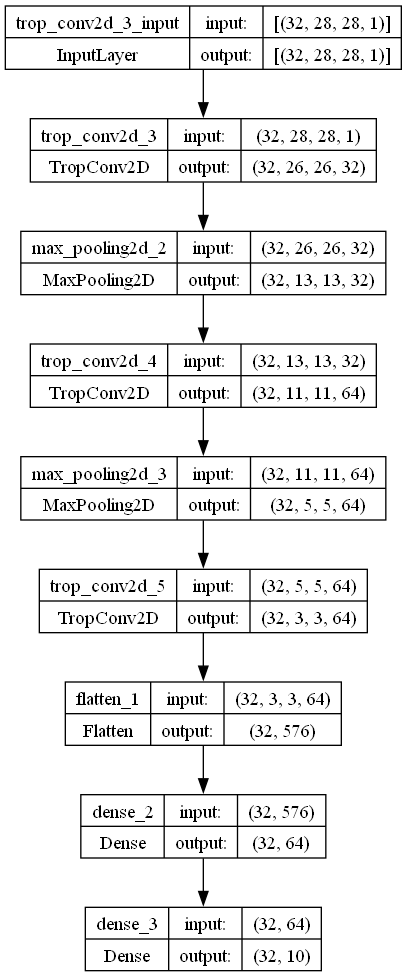

In [4]:
initializer_trop = BimodalNormalInitializer(stddev=1,high=5.5, low=-4.5)
initializer_relu = initializers.RandomNormal(mean=0.5, stddev=1., seed=0)
lam = 0
in_channels = 1
model = Sequential([TropConv2D(filters=32, channels=in_channels, window_size = [1, 3, 3, 1], strides = [1, 1, 1, 1], initializer_w=initializer_trop, lam=lam),
                    MaxPooling2D((2, 2)),                            
                    TropConv2D(filters=64, channels=32, window_size = [1, 3, 3, 1], strides = [1, 1, 1, 1], initializer_w=initializer_trop, lam=lam),
                    MaxPooling2D((2, 2)),
                    TropConv2D(filters=64, channels=64, window_size = [1, 3, 3, 1], strides = [1, 1, 1, 1], initializer_w=initializer_trop, lam=lam),
                    Flatten(),
                    Dense(64, activation='relu', kernel_initializer = initializer_relu),
                    Dense(10, activation='softmax', kernel_initializer = initializer_relu)])
model.build(input_shape=(32, 28, 28, 1))
#model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### RELU: Basic 3 convolutional layers model

In [24]:
# -- RELU: fit model --
relu_model = conv_relu_3layer_model(x_train=x_train, y_train=y_train)

# -- RELU: attack model -- 
relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test, losses.CategoricalCrossentropy(),'ReLU')

# -- RELU: evaluate --
# - before attack -
pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
y_tester = np.argmax(y_test, axis=1)
pre_correct_index = np.equal(pre_relu_preds, y_tester)
pre_correct_accuracy = np.average(pre_correct_index)
relu_model.evaluate(x_test, y_test)

# - after attack - 
post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
post_correct_index = np.equal(post_relu_preds, y_tester)
post_correct_accuracy = np.average(post_correct_index)
relu_model.evaluate(relu_x_test_att, y_test)

# - number maintaining prediction - 
maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))
print(pre_correct_accuracy, post_correct_accuracy, maintained_correct_pred)

Epoch 1/10
938/938 [==============================] - 91s 97ms/step - loss: 0.5999 - accuracy: 0.8354
Epoch 2/10
938/938 [==============================] - 86s 91ms/step - loss: 0.1048 - accuracy: 0.9679
Epoch 3/10
938/938 [==============================] - 89s 95ms/step - loss: 0.0747 - accuracy: 0.9766
Epoch 4/10
938/938 [==============================] - 87s 93ms/step - loss: 0.0583 - accuracy: 0.9821
Epoch 5/10
938/938 [==============================] - 90s 96ms/step - loss: 0.0479 - accuracy: 0.9854
Epoch 6/10
938/938 [==============================] - 88s 94ms/step - loss: 0.0411 - accuracy: 0.9873
Epoch 7/10
938/938 [==============================] - 89s 95ms/step - loss: 0.0376 - accuracy: 0.9884
Epoch 8/10
938/938 [==============================] - 88s 93ms/step - loss: 0.0313 - accuracy: 0.9901
Epoch 9/10
938/938 [==============================] - 88s 94ms/step - loss: 0.0298 - accuracy: 0.9906
Epoch 10/10
938/938 [==============================] - 89s 95ms/step - loss: 0.023